In [3]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Import Libraries

In [4]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment


# 2. Load Data

In [5]:
data = pd.read_csv('../Dataset/household_power_consumption.txt', sep=';', 
                parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                low_memory=False, na_values=['nan','?'], index_col='dt').drop_duplicates().dropna()

data

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[1906698 rows x 7 columns]

# 3. Initial Analysis

### 3.1. Metadata

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1906698 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 116.4 MB


In [11]:
data.describe().transpose()

count        mean       std      min      25%  \
Global_active_power    1906698.0    1.149514  1.069633    0.076    0.328   
Global_reactive_power  1906698.0    0.131717  0.112180    0.000    0.058   
Voltage                1906698.0  240.756233  3.272622  223.200  238.870   
Global_intensity       1906698.0    4.875611  4.493424    0.200    1.400   
Sub_metering_1         1906698.0    1.205428  6.370211    0.000    0.000   
Sub_metering_2         1906698.0    1.393690  6.024298    0.000    0.000   
Sub_metering_3         1906698.0    6.803191  8.540984    0.000    0.000   

                           50%      75%      max  
Global_active_power      0.746    1.576   11.122  
Global_reactive_power    0.106    0.202    1.390  
Voltage                240.920  242.820  254.150  
Global_intensity         3.200    6.600   48.400  
Sub_metering_1           0.000    0.000   88.000  
Sub_metering_2           0.000    1.000   80.000  
Sub_metering_3           1.000   18.000   31.000

In [12]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Columns Processing

In [6]:
def change_dtypes(data):    
    data['Global_active_power'] = data['Global_active_power'].astype('float16')
    data['Global_reactive_power'] = data['Global_reactive_power'].astype('float16')
    data['Voltage'] = data['Voltage'].astype('float16')
    data['Global_intensity'] = data['Global_intensity'].astype('float16')
    data['Sub_metering_1'] = data['Sub_metering_1'].astype('float16')
    data['Sub_metering_2'] = data['Sub_metering_2'].astype('float16')
    data['Sub_metering_3'] = data['Sub_metering_3'].astype('float16')
    return data

data = change_dtypes(data) 

In [7]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Categorical Columns : []


In [13]:
# LE = LabelEncoder()

# for idx, column in enumerate(categorical_columns):
#     data[column] = LE.fit_transform(data[column])
#     data[column] = data[column].astype('int8')

### 3.3. EDA

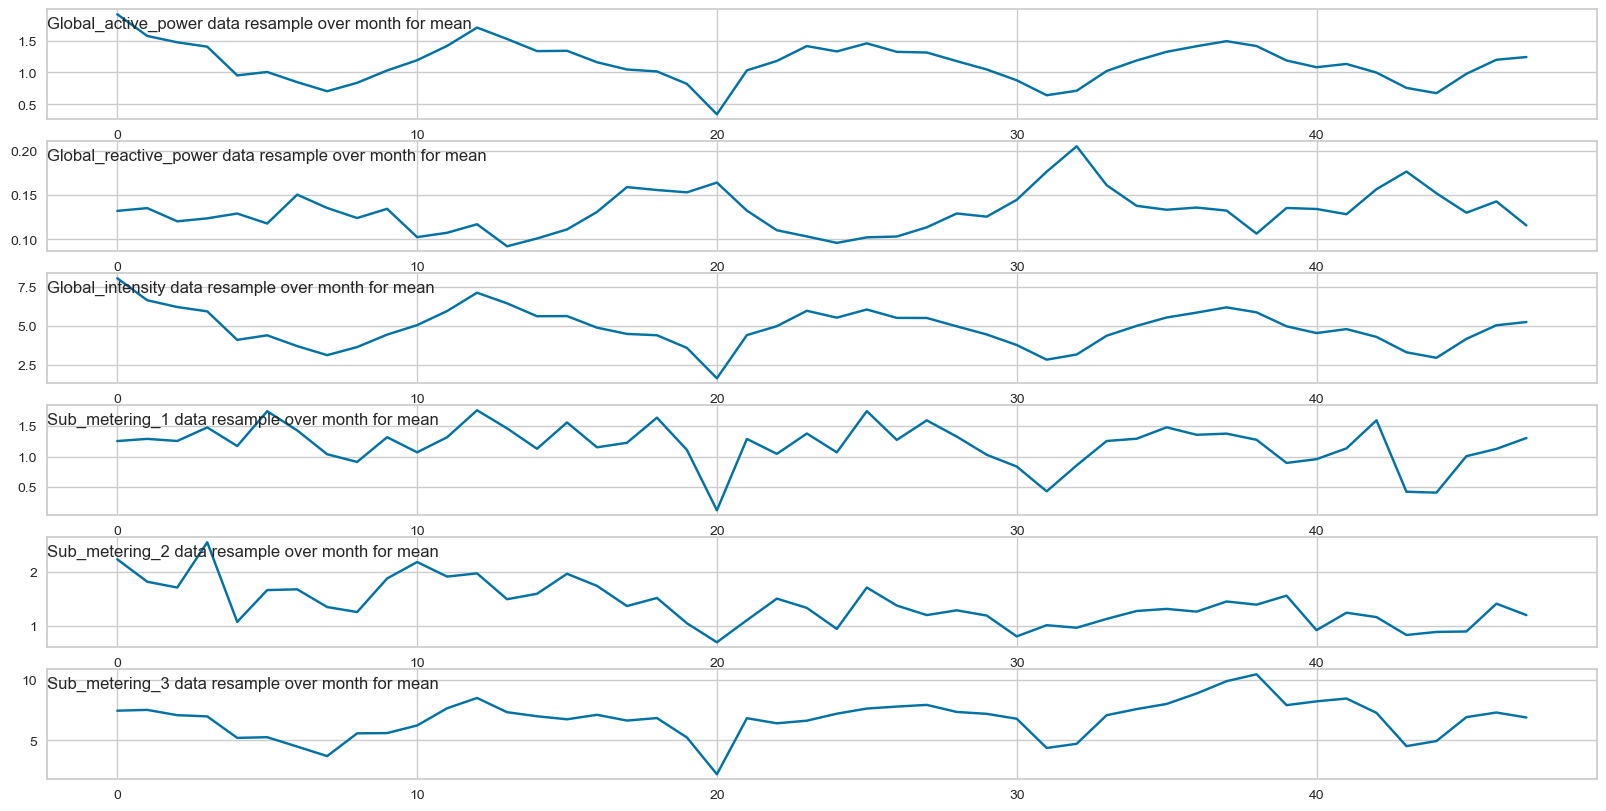

In [60]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(data.resample('M').mean().values[:, col])
    plt.title(data.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

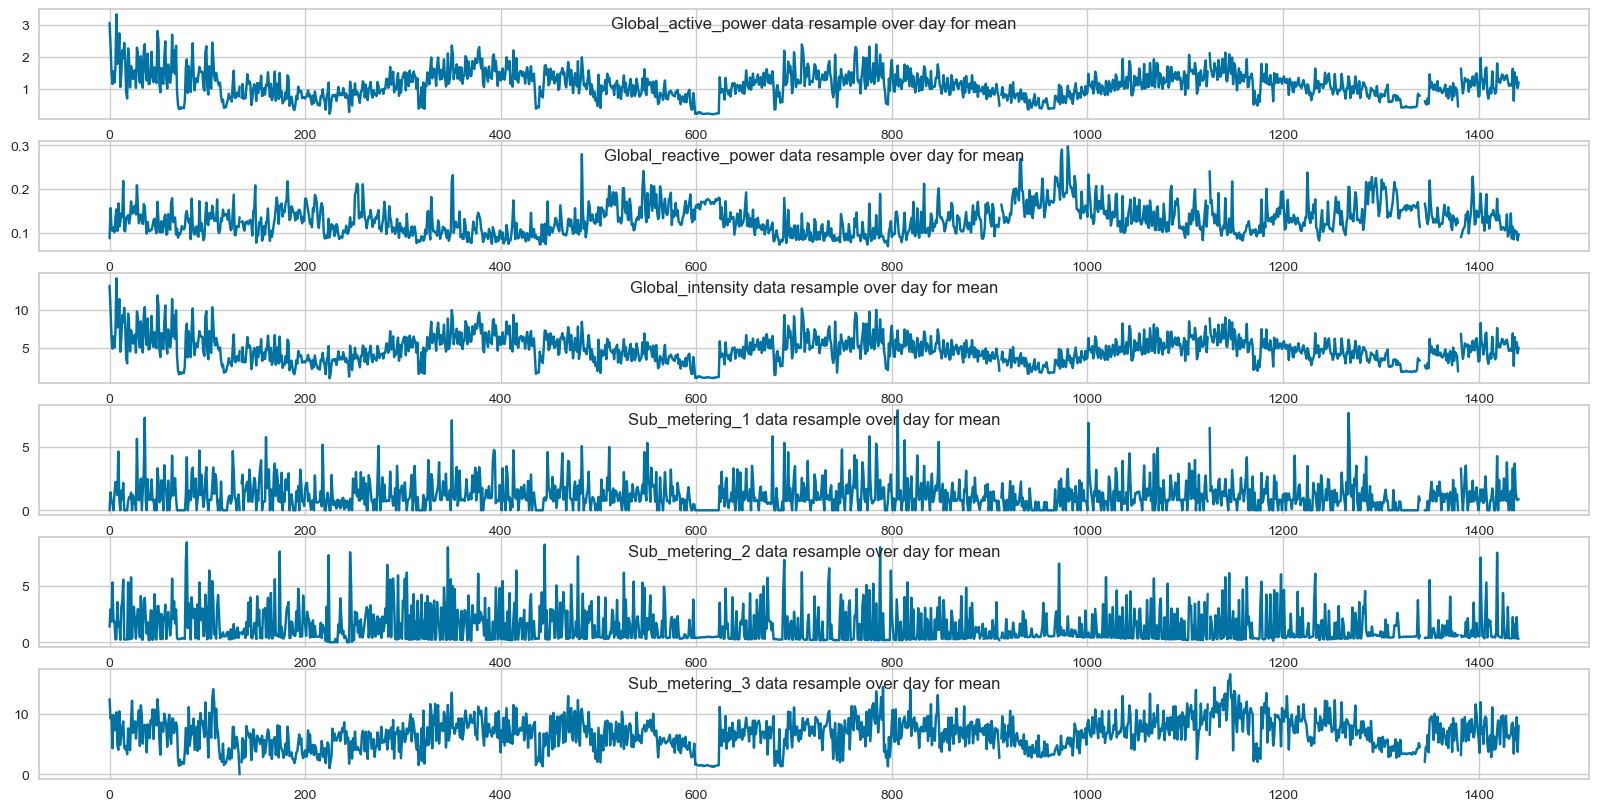

In [61]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(data.resample('D').mean().values[:, col])
    plt.title(data.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

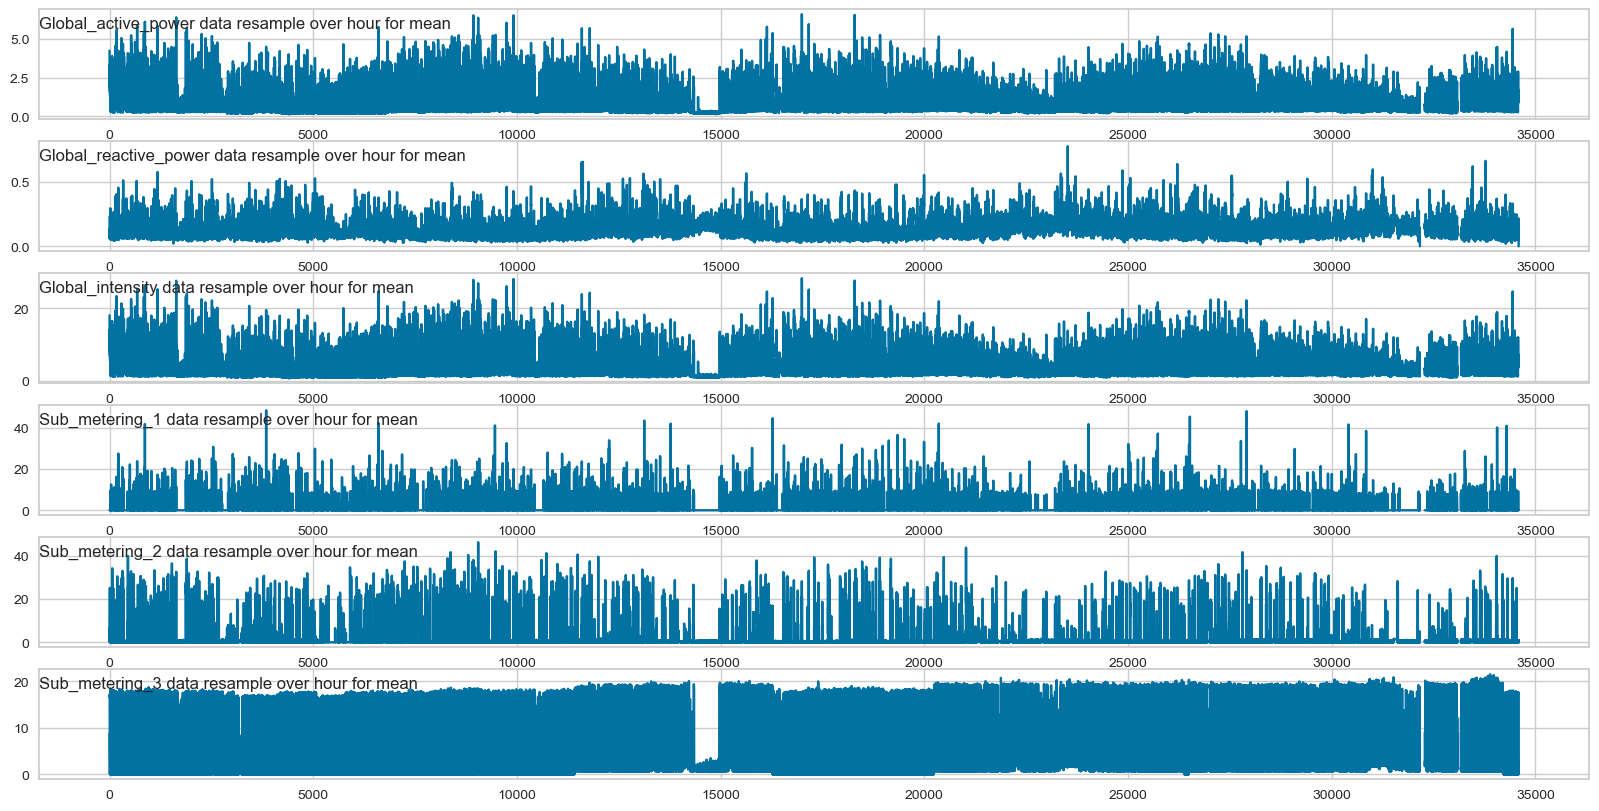

In [62]:

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(data.resample('H').mean().values[:, col])
    plt.title(data.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

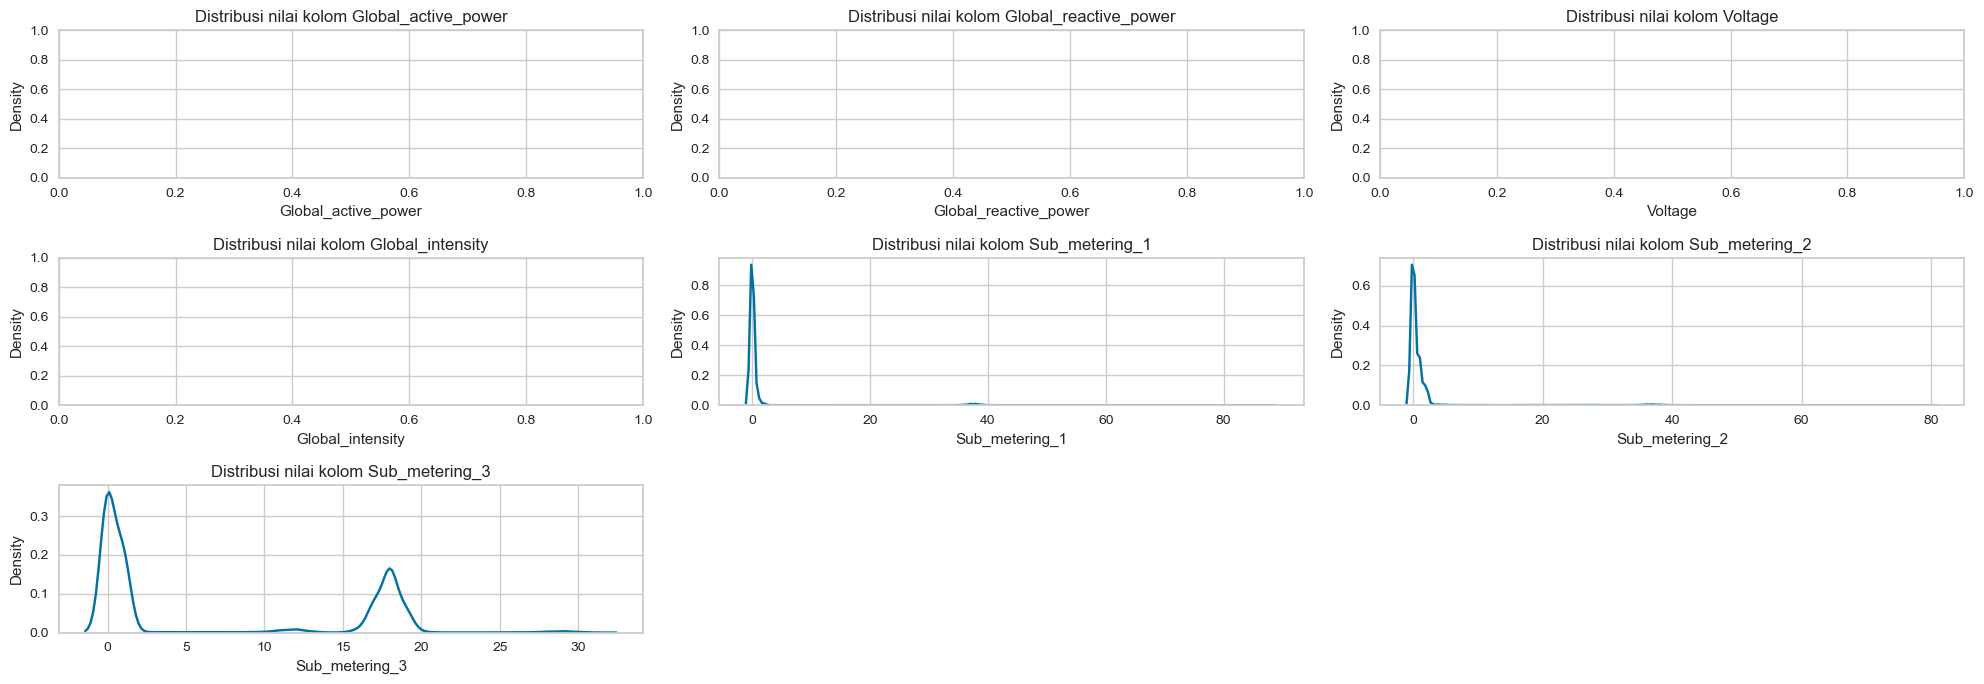

In [53]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="cut", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

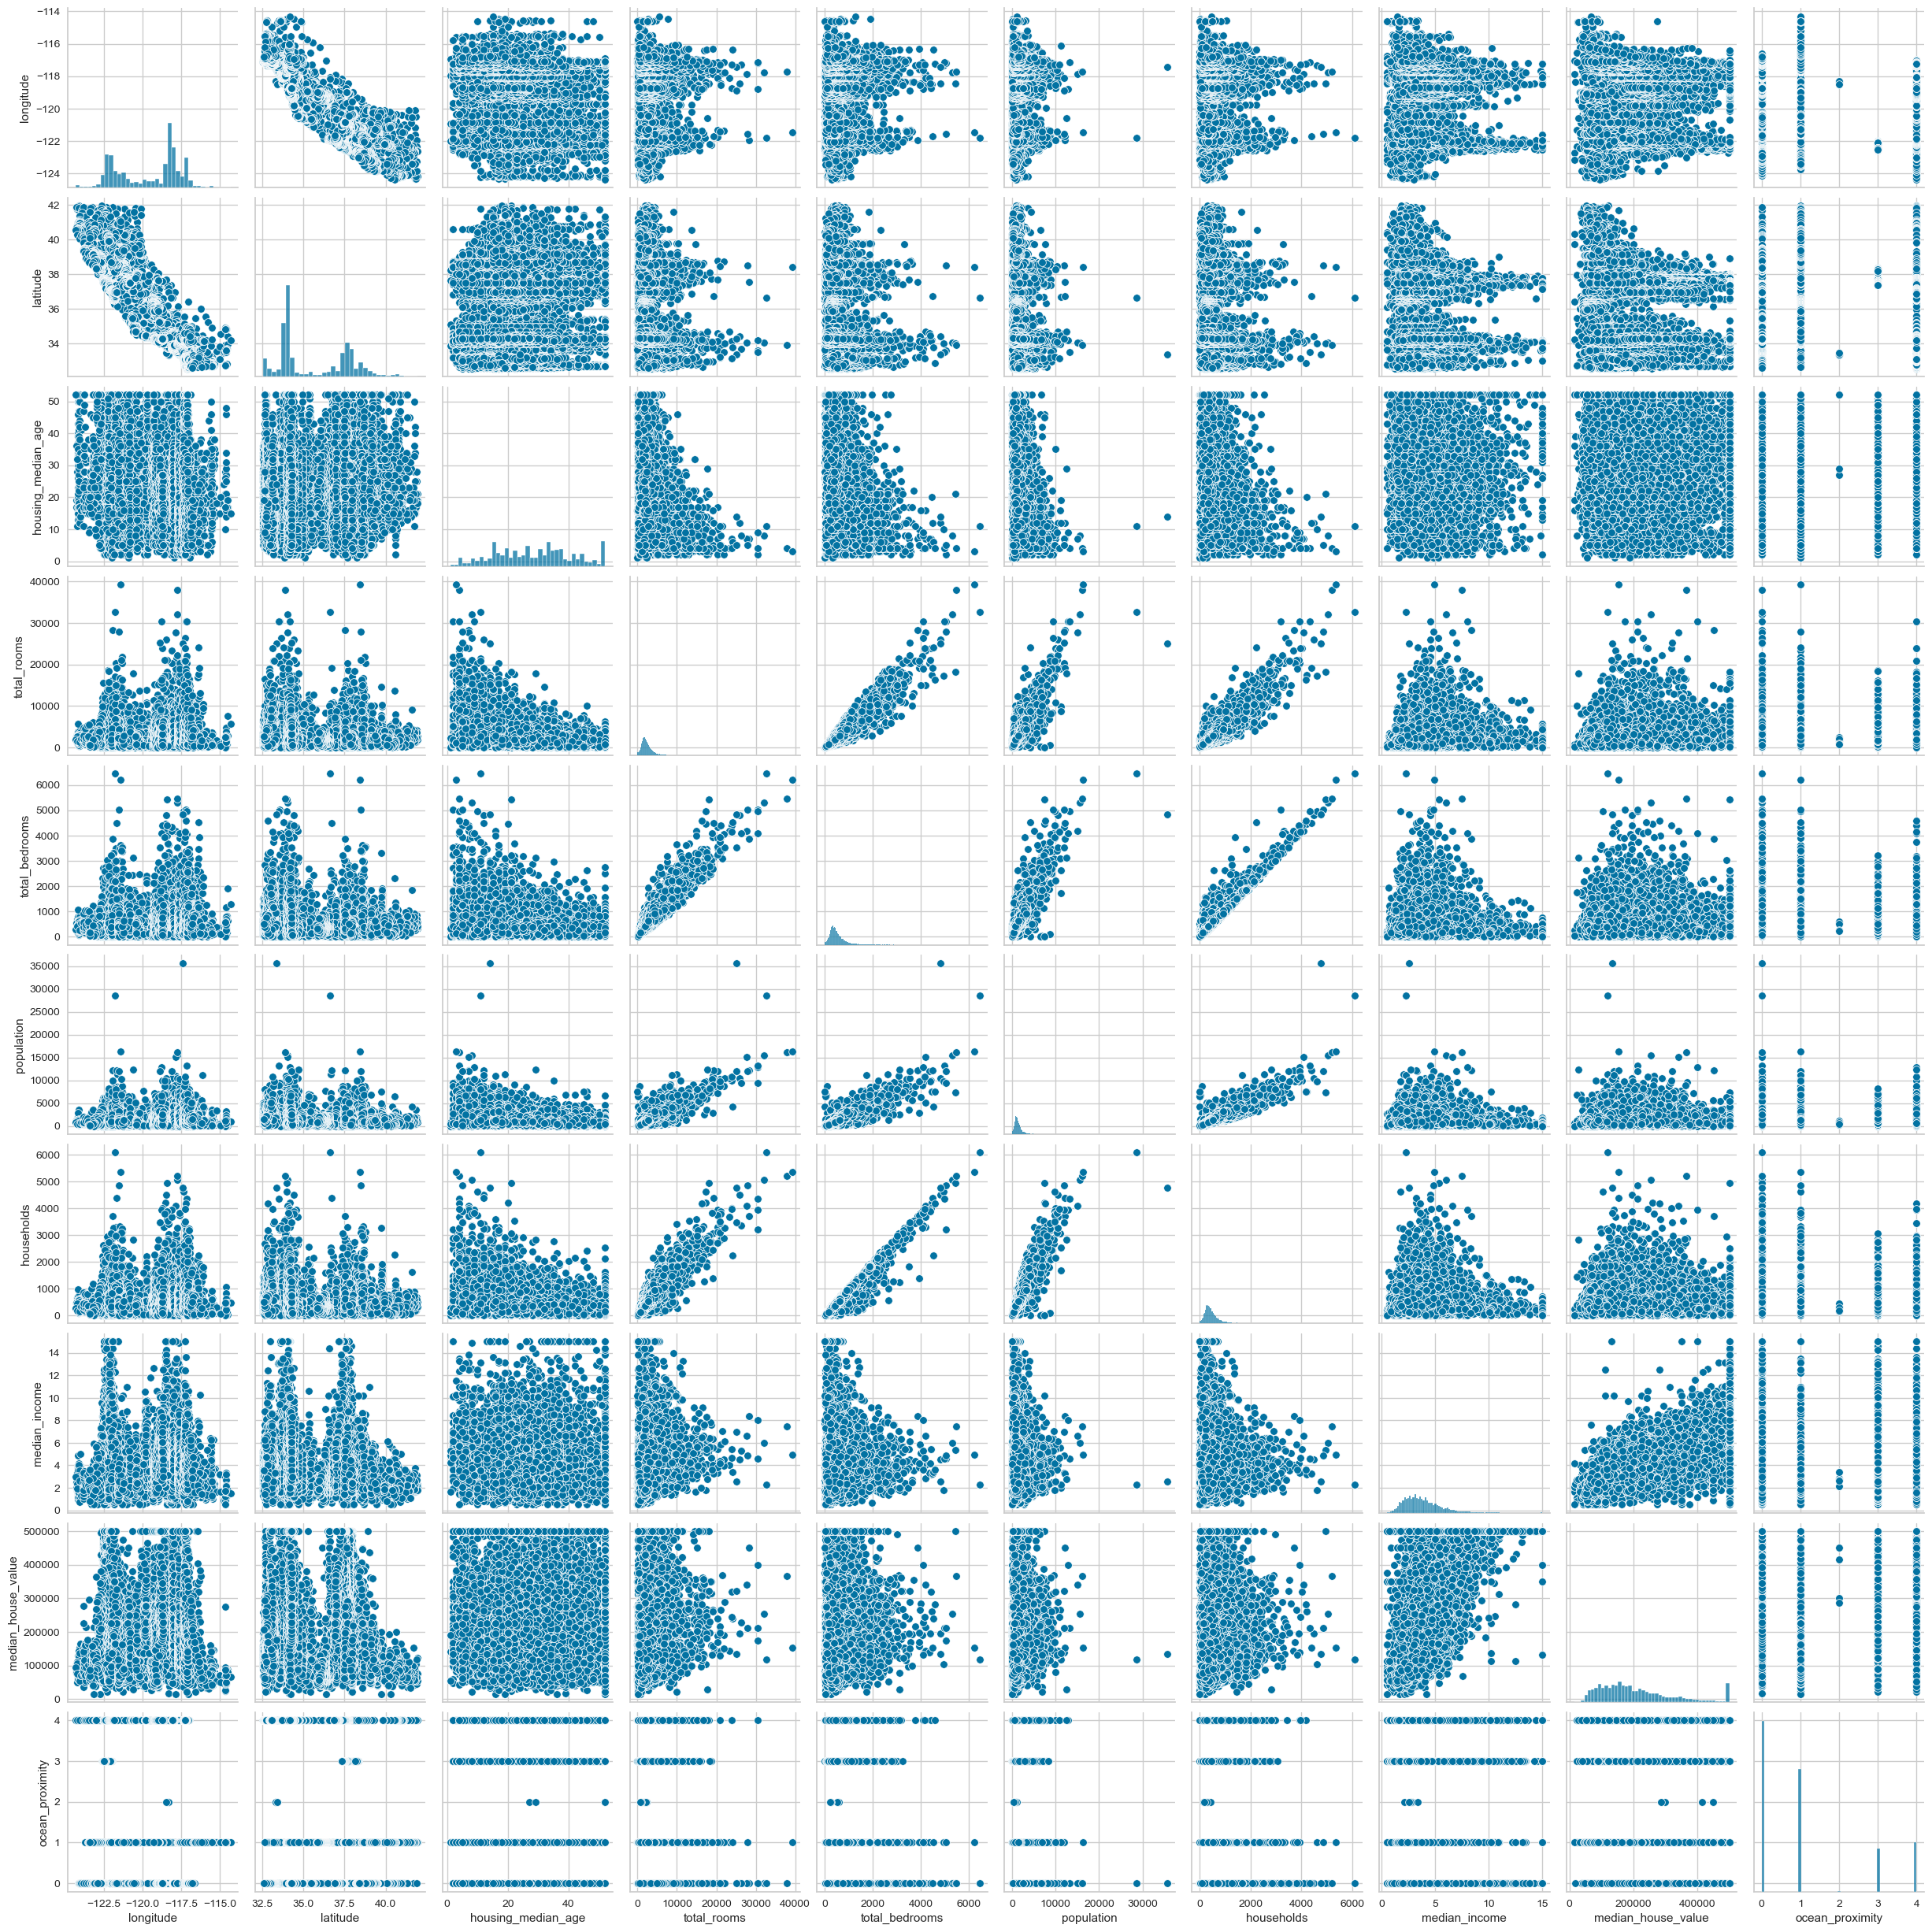

In [16]:
sns.pairplot(data)

[Text(0, 0, '1609'),
 Text(0, 0, '4902'),
 Text(0, 0, '21548'),
 Text(0, 0, '13780'),
 Text(0, 0, '12081')]

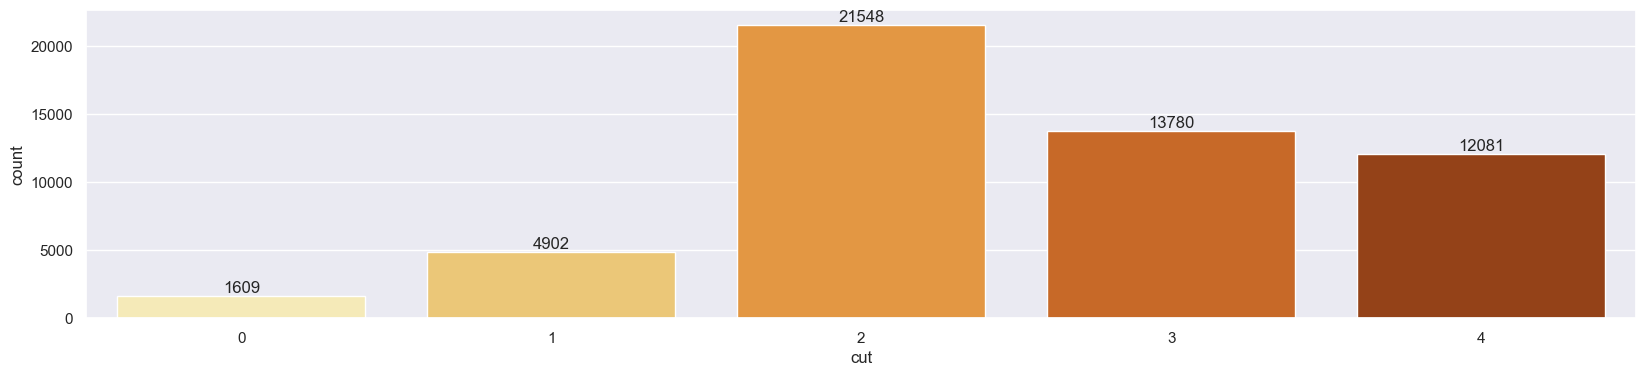

In [8]:
plt.subplots(figsize = (20,4))
ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
ax.bar_label(ax.containers[0])

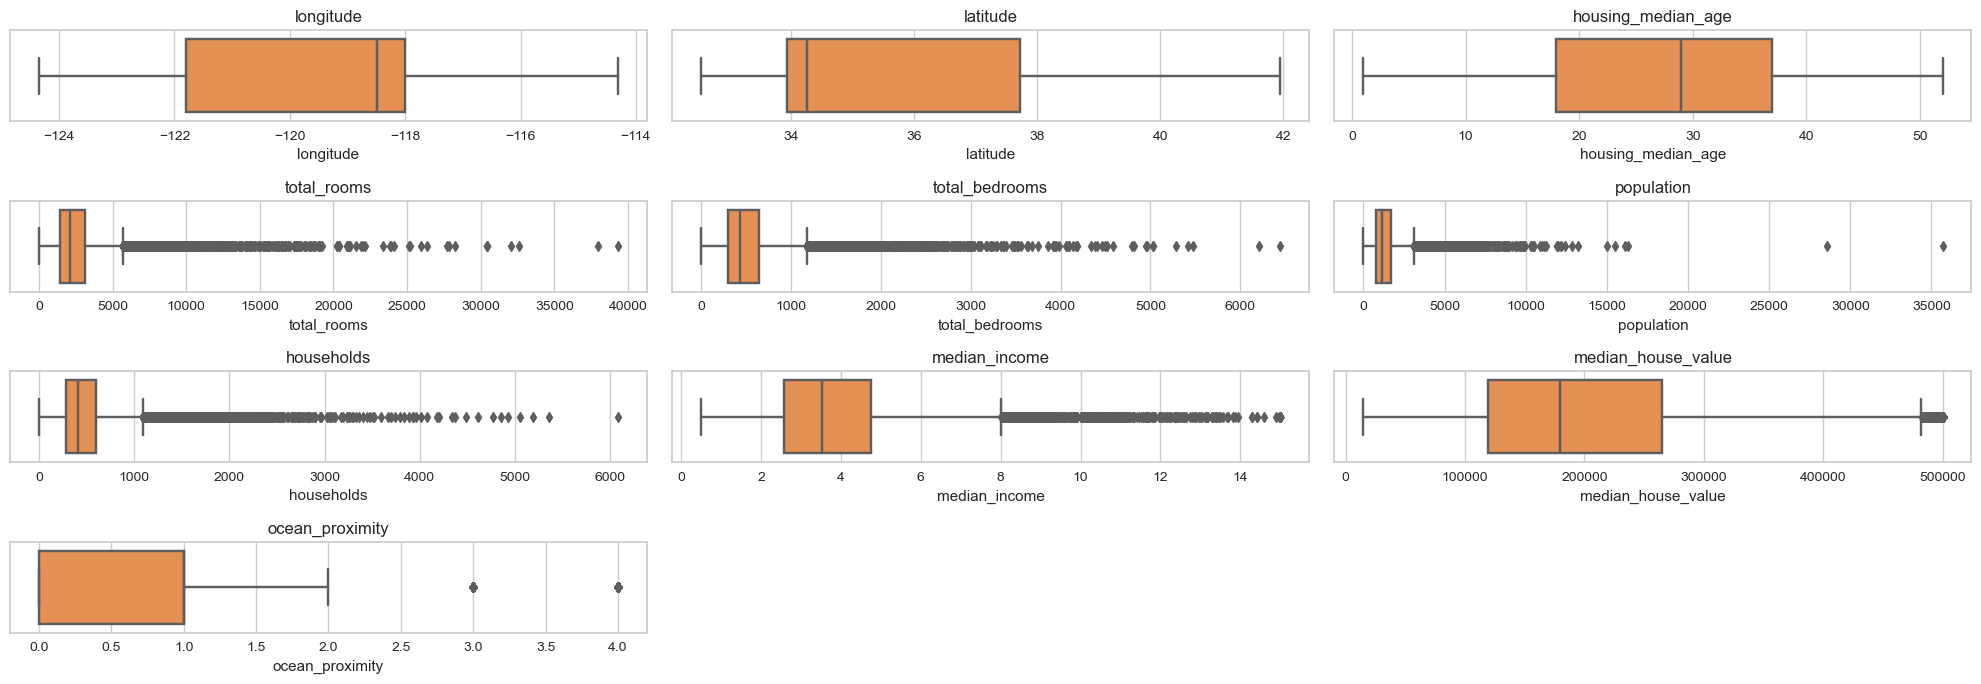

In [17]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

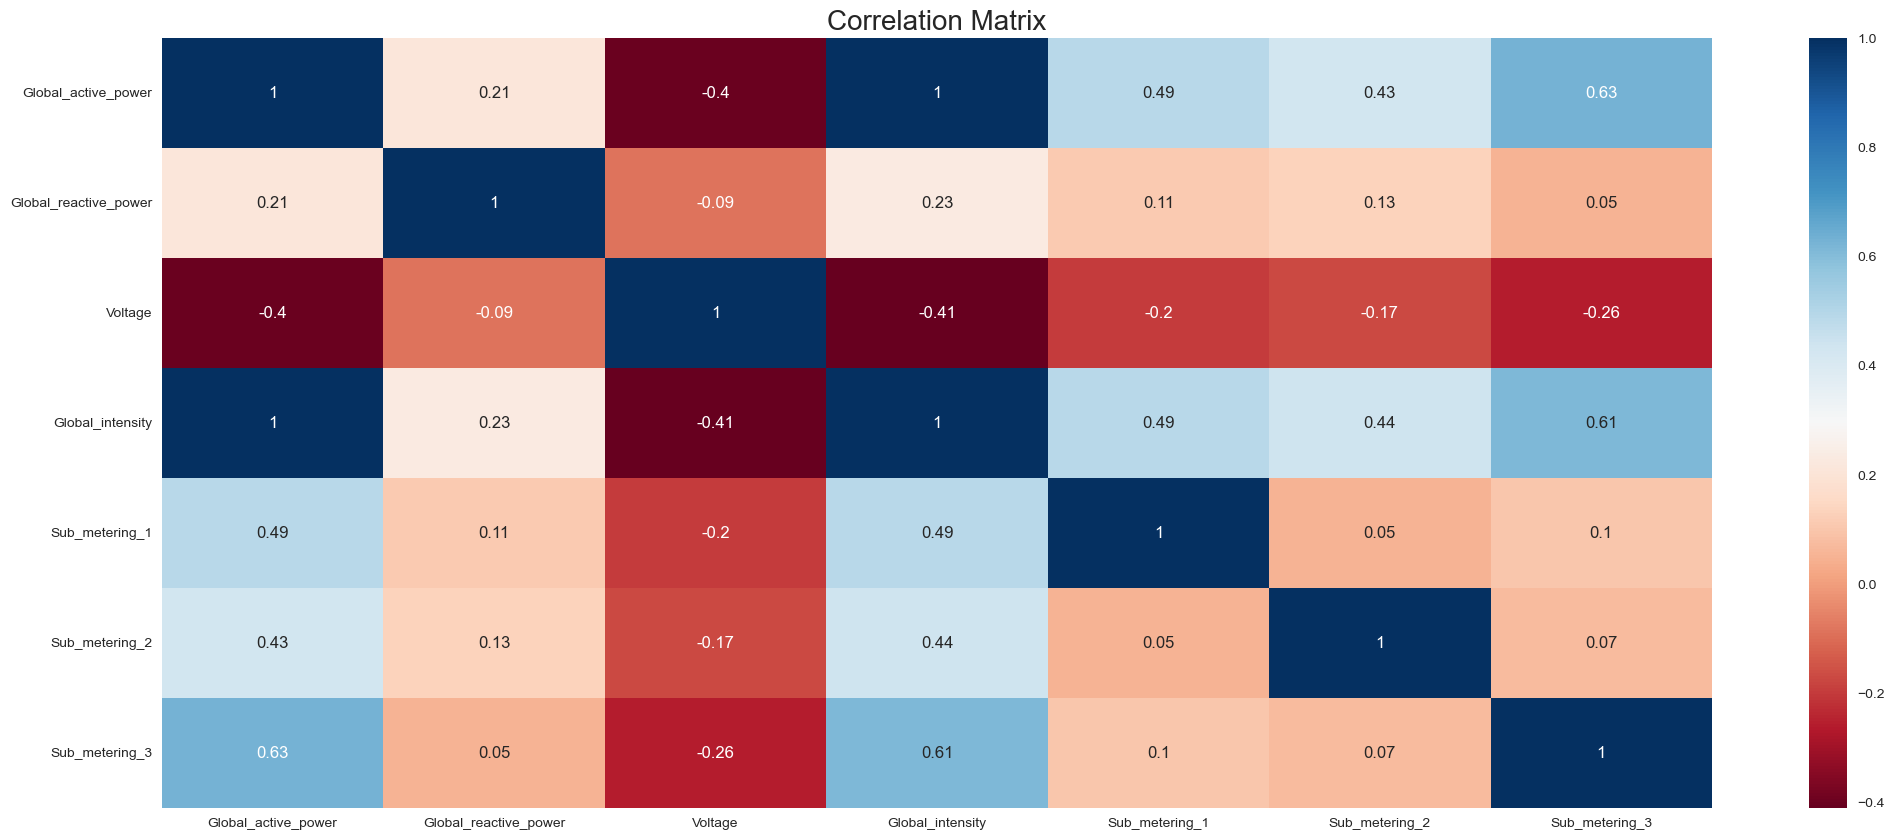

In [63]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Time-Series Features

In [19]:
data = data[['Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]
    
def series_to_supervised(data, n_in, n_out):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]       
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        agg.dropna(inplace=True)
    return agg

In [20]:
data_resample = data.resample('h').mean() 
# data_resample.shape

values = data_resample.values

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

reframed = series_to_supervised(values, 10, 1)
r = list(range(data_resample.shape[1]+1, 2*data_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

var1(t-10)  var2(t-10)  var3(t-10)  var4(t-10)  var5(t-10)  var6(t-10)  \
0    1.662193    0.079531  244.504166    7.206152    0.766667         0.0   
1    2.215763    0.093465  243.858337    9.333040    0.566667         0.0   
2    1.996786    0.060235  243.712494    8.566731    0.166667         0.0   
3    1.303247    0.094839  244.145828    5.529915    0.716667         0.0   
4    1.620085    0.059796  241.839584    6.802686    0.166667         0.0   

   var7(t-10)  var1(t-9)  var1(t-8)  var2(t-8)  ...  var5(t-1)  var6(t-1)  \
0    0.000000   1.587187   3.349369   0.136934  ...   6.716667        0.0   
1    8.883333   1.662193   1.587187   0.078229  ...   1.433333        0.0   
2    4.650000   2.215763   1.662193   0.079531  ...   0.000000        0.0   
3    0.000000   1.996786   2.215763   0.093465  ...   0.416667        0.0   
4    0.000000   1.303247   1.996786   0.060235  ...   0.133333        0.0   

   var7(t-1)   var1(t)   var2(t)     var3(t)    var4(t)   var5(t)  var6(t)  \
0  16.866667  4.222982  0.228984  234.645828  18.099609  0.527778      0.0   
1  16.683332  3.632064  0.080035  234.574997  15.600261  6.716667      0.0   
2  16.783333  3.400260  0.085234  233.243744  14.502474  1.433333      0.0   
3  17.216667  3.268555  0.075101  234.064590  13.916276  0.000000      0.0   
4   4.433333  3.056673  0.076670  237.166672  13.046810  0.416667      0.0   

     var7(t)  
0  16.861111  
1  16.866667  
2  16.683332  
3  16.783333  
4  17.216667  

[5 rows x 71 columns]

In [19]:
# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
train_x.shape[0], train_x.shape[1], train_x.shape[2]

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=10, batch_size=70, validation_data=(test_x, test_y), verbose=1, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = data_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(data.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()

### 4.3. Data Splitting

In [262]:
values = reframed.values
n_train_time = 5000

# train = values[:n_train_time, :]
# test = values[n_train_time:, :]

# X_train, y_train = train[:, :-1], train[:, -1]
# X_test, y_test = test[:, :-1], test[:, -1]

# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [23]:
values = reframed.values

X = values[:, :-1]
Y = values[:, -1]

# X = data.drop(columns=['median_house_value'])
# Y = data['median_house_value']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(23911, 70)
(6745, 70)
(3407, 70)


# 5. Neural Network Algoritms

In [34]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    # model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(64))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(512, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_1)

model.compile(loss='mse', optimizer=opt)
# model.compile(loss='mae', optimizer = opt)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 70, 512)           791040    
                                                                 
 gru_6 (GRU)                 (None, 70, 256)           591360    
                                                                 
 gru_7 (GRU)                 (None, 128)               148224    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,530,753
Trainable params: 1,530,753
Non-trainable params: 0
_________________________________________________________________


In [35]:
num_epoch = 10
batch_size = 32

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test),
                    shuffle=False)

Epoch 1/10
748/748 [==============================] - 28s 33ms/step - loss: 35.7657 - mse: 35.7657 - val_loss: 29.1411 - val_mse: 29.1411
Epoch 2/10
748/748 [==============================] - 23s 31ms/step - loss: 26.0586 - mse: 26.0586 - val_loss: 25.4913 - val_mse: 25.4913
Epoch 3/10
748/748 [==============================] - 23s 30ms/step - loss: 22.0213 - mse: 22.0213 - val_loss: 22.5999 - val_mse: 22.5999
Epoch 4/10
748/748 [==============================] - 22s 30ms/step - loss: 19.9780 - mse: 19.9780 - val_loss: 21.2849 - val_mse: 21.2849
Epoch 5/10
748/748 [==============================] - 22s 30ms/step - loss: 18.8538 - mse: 18.8538 - val_loss: 20.3320 - val_mse: 20.3320
Epoch 6/10
748/748 [==============================] - 23s 30ms/step - loss: 17.7508 - mse: 17.7508 - val_loss: 19.0913 - val_mse: 19.0913
Epoch 7/10
748/748 [==============================] - 23s 30ms/step - loss: 16.5207 - mse: 16.5207 - val_loss: 17.1912 - val_mse: 17.1912
Epoch 8/10
748/748 [==============

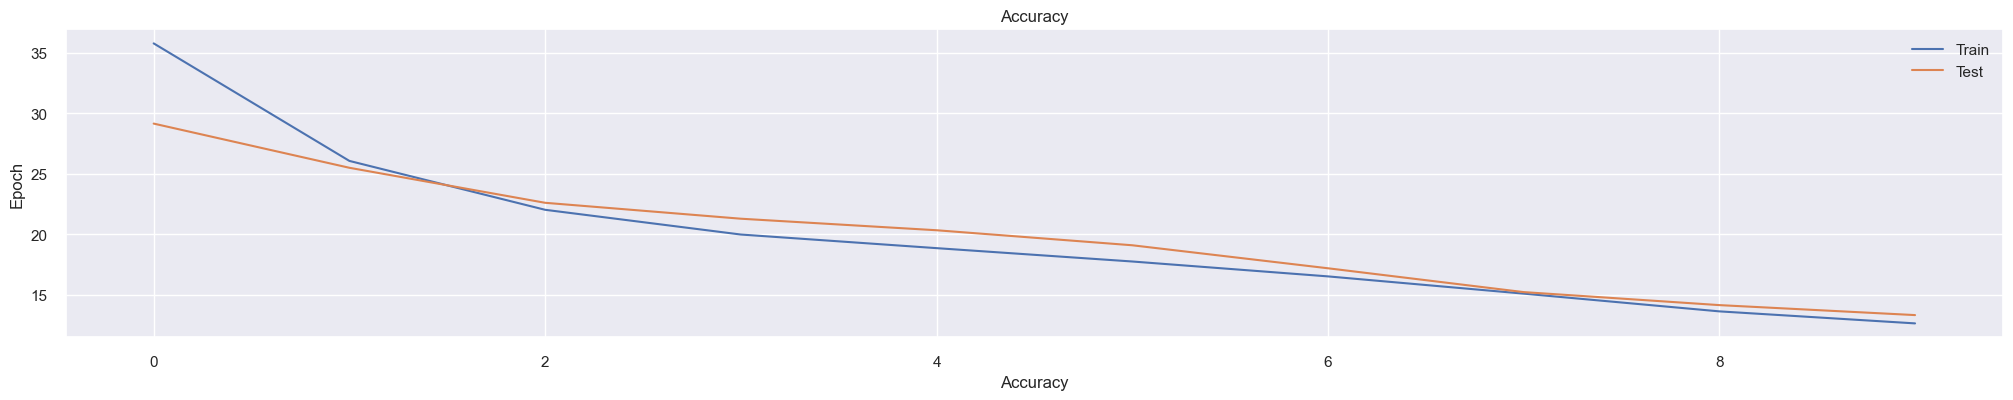

In [36]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [37]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 4))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 4))

R Squared Error    : 0.7509
Mean Squared Error : 13.324


In [38]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].mean(), '/', train_results['Diff'].sum())

   Train Predictions    Actuals       Diff
0          15.201743  17.627119   2.425376
1          13.269618   1.883333  11.386285
2           2.311646   7.051724   4.740078
3           1.622186   8.821428   7.199242
4          11.253882   1.616667   9.637216
2.383231 / 16074.893


# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [72]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('knn', knn),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    # ('gradient', gradient),
], n_jobs=-1)

In [73]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42))],
                  n_jobs=-1)

In [74]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))

Train Score        : 92.04 %
Test Score         : 84.62 %
R Squared Error    : 0.85
Mean Squared Error : 1950346256.13


In [76]:
train_predictions = np.rint(model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(round(train_results['Diff'].mean()), '/', round(train_results['Diff'].sum()))

       Train Predictions   Actuals      Diff
7736            166273.0  195800.0   29527.0
12418            66217.0   82200.0   15983.0
4132            236294.0  214200.0   22094.0
6445            308942.0  447100.0  138158.0
7952            157248.0  167000.0    9752.0
29511 / 119403057


### 6.2. Pycarets

In [13]:
s = RegressionExperiment()
s.setup(data, target = 'price', session_id = 123)

In [14]:
best = s.compare_models()
print(best)

Initiated  . . . . . . . . . . . . . . . . . .              20:24:29
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [ ]:
s.evaluate_model(best)

In [16]:
s.predict_model(best)

carat  cut  color  clarity      depth  table     x     y     z  price  \
47295   0.30    1      2        3  63.400002   56.0  4.26  4.29  2.71    394   
52309   0.31    2      0        2  62.299999   56.0  4.32  4.35  2.70    548   
3825    0.73    2      1        4  61.400002   55.0  5.80  5.82  3.57   3471   
45257   0.51    2      2        5  61.599998   57.0  5.14  5.15  3.17   1661   
8585    1.01    4      5        5  61.299999   56.0  6.53  6.45  3.98   4438   
...      ...  ...    ...      ...        ...    ...   ...   ...   ...    ...   
13768   1.35    4      6        2  61.099998   61.0  7.10  7.13  4.35   5613   
46340   0.50    1      0        5  63.700001   56.0  5.09  5.05  3.23   1758   
47227   0.60    2      0        2  62.299999   57.0  5.42  5.37  3.36   1840   
22661   1.26    2      2        5  61.500000   56.0  6.97  7.01  4.30  10709   
13942   1.30    3      4        2  62.900002   60.0  6.95  6.88  4.35   5671   

       prediction_label  
47295        486.420649  
52309        682.183706  
3825        3510.702591  
45257       1652.668495  
8585        4476.470241  
...                 ...  
13768       5533.372564  
46340       1613.025171  
47227       1804.547772  
22661       9923.811775  
13942       6593.265576  

[16176 rows x 11 columns]